# Tutorial IV: Convolutions in pytorch

<p>
Bern Winter School on Machine Learning, 2024<br>
Prepared by Mykhailo Vladymyrov and Matthew Vowels.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will look at the convolution operation and try to build some intuition about it.
Also we will look at one of the state-of-the art deep models, [Inception](https://arxiv.org/abs/1602.07261). It is designed to perform image recognition.

## 1. Load necessary libraries

In [1]:
colab = False # set to True is using google colab

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import sys
import shutil
import tarfile

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.hub import download_url_to_file
from torchvision import transforms

from scipy.ndimage import rotate


### Download libraries

In [3]:
if colab:
    path = os.path.join(os.path.abspath('.')+'material.tgz')
    url = 'https://github.com/neworldemancer/BMLWS/raw/main/tut_files/tpub0320.tgz'
    # p = tf.keras.utils.get_file(path, url)
    # Download compressed file with torch utils

    download_url_to_file(url=url, dst=path)

    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

## 2. Images

What is an image?

## 3. Convolutions

In a fully connected network all inputs of a layer are connected to all neurons of the following layer:
<tr>
    <td> <img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/Perceptron.png" alt="drawing" width="30%"/></td>
    <td> <img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/MLP.png" alt="drawing" width="50%"/></td>
</tr>
<br>In convolutional nets the same holds true for each neighbourhood, and the weights are shared:<br>
<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/CNN1.png" alt="drawing" width="50%"/><br>
<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/CNN2.png" alt="drawing" width="50%"/><br>
<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/CNN3.png" alt="drawing" width="50%"/><br>


Let's see what a convolution is, and how it behaves.

### 1.1. Handkrafting filters

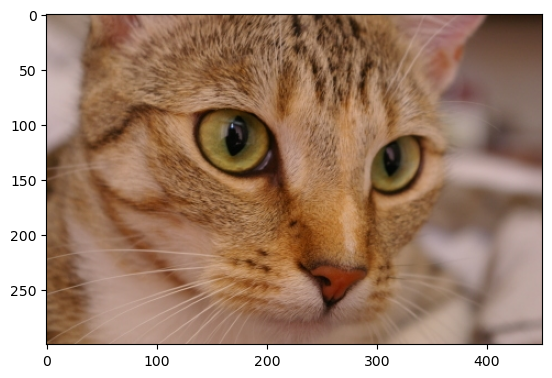

In [6]:
# load image
img_raw = plt.imread('ML3/chelsea.jpg')  # load RGB image (HWC)
plt.imshow(img_raw)  # show image
plt.grid(False)  # disable grid

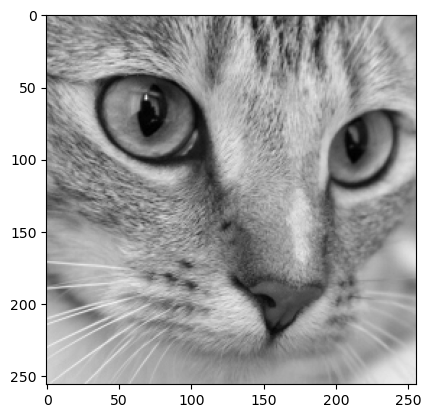

In [7]:
# convert to gray-scale and normalize

img_raw = img_raw.mean(axis=2)  # convert to gray-scale by averaging over color channels
img_raw = img_raw[-256:, 100:356]  # crop to 256x256 pixels
img_raw = img_raw.astype(np.float32)  # convert to float32
img_raw = (img_raw-img_raw.mean())/img_raw.std()  # normalize to zero mean and unit variance

plt.imshow(img_raw, cmap='gray')  # show image
plt.grid(False)  # disable grid

In [108]:
def conv_2d(x, flt):
    # x: B (batch size), C (input channels), H (height), W (width)
    # flt: Co (output channels), Ci (input channels), Hf (filter height), Wf (filter width)
    return F.conv2d(input=x, weight=flt, stride=1, padding=0, dilation=10)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

    @staticmethod
    def forward(x, flt):
        print(x.shape, flt.shape)  # Print the shapes of input and filter tensors
        y1 = conv_2d(x, flt)        # First convolutional layer
        y2 = conv_2d(y1, flt)       # Second convolutional layer
        y3 = conv_2d(y2, flt)       # Third convolutional layer
        y4 = conv_2d(y3, flt)       # Fourth convolutional layer
        return x, y1, y2, y3, y4    # Return the input and the results of each convolutional layer

In [109]:
# Check if a GPU (CUDA) is available and assigns the appropriate device to the variable device
# If a GPU is available (torch.cuda.is_available() is True), it assigns the string "cuda:0" to device. 
# If no GPU is available (torch.cuda.is_available() is False), it assigns the string "cpu".

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [110]:
# Create instance of Model class and ensure that the "device" hardware is used
model = Model().to(device)

In [111]:
def get_convolved(img, flt):
    # Add batch (1) and channel (1) dimensions to the input image
    img_raw4d = img[np.newaxis, np.newaxis]

    # Convert the filter to a NumPy array of float32 and add dimensions for N channels out (1) and N channels in (1)
    flt_mtx_np = np.array(flt, np.float32)
    flt_mtx_np = flt_mtx_np[np.newaxis, np.newaxis]

    # Convert the NumPy arrays to PyTorch tensors and move them to the specified device (GPU or CPU)
    img_raw4d_t = torch.from_numpy(img_raw4d).to(device)
    flt_mtx_t = torch.from_numpy(flt_mtx_np).to(device)

    # Perform convolution using the model, returning a list of PyTorch tensors
    res = model(img_raw4d_t, flt_mtx_t)

    # Disable gradient tracking, move to CPU, and convert the result tensors to NumPy arrays
    res = [r.detach().cpu().numpy() for r in res]

    # Remove batch and channel dimensions, keeping only the output channel
    res = [r[0, 0] for r in res]

    return res


Let's experiment with filter kernels:

torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 5, 5])
(256, 256)
(216, 216)
(176, 176)
(136, 136)
(96, 96)


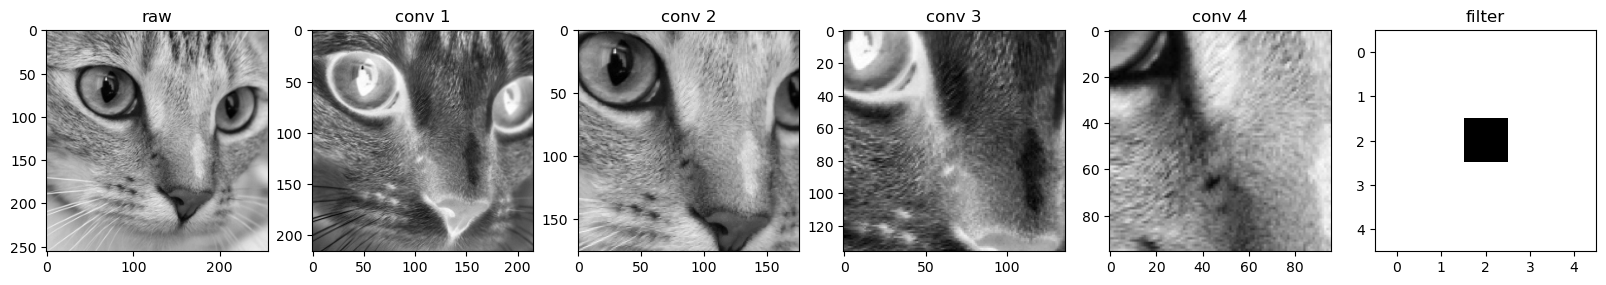

In [112]:
flt_mtx = [
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, -1, 0, 0,],
    [ 0, 0, 0, 0, 0,],
    [ 0, 0, 0, 0, 0,],
] # identity transformation

#flt_mtx = [
##    [ 1, 1, 1, 1, 1,],
#    [ 1, 1, 1, 1, 1,],
#    [ 1, 1, 1, 1, 1,],
#    [ 1, 1, 1, 1, 1,],
#    [ 1, 1, 1, 1, 1,],
#] # box filter

#flt_mtx = [
#    [ 0, 1, -1, 1, 0,],
#    [ 0, 1, -1, 1, 0,],
#    [ 0, 1, -1, 1, 0,],
#    [ 0, 1, -1, 1, 0,],
#    [ 0, 1, -1, 1, 0,],
#] # edge detection with + and - bands

ims_convolved = get_convolved(img_raw, flt_mtx)

n = len(ims_convolved)
fig, ax = plt.subplots(1, n+1, figsize=(n*4, 4))
for col in range(n):
    ax[col].imshow(ims_convolved[col], cmap='gray')  #, vmin=-3, vmax=3
    ax[col].grid(False)
    ax[col].set_title('conv %d'% col if col else 'raw')
    print(ims_convolved[col].shape)

ax[n].imshow(flt_mtx, cmap='gray')
ax[n].grid(False)
_=ax[n].set_title('filter')


1. experiment with different filters and understand what they do, e.g.:<br>
- identity transformation
- identity transformation with positive non-unit values
- identity transformation with negative unit value
- identity transformation off center
- blurring with box filter
- edge detection with + and - bands
- try whatever you like

2. experiment with convolution parameters: <br>
- padding = 1, 2, 3
- stride = 2
- dilation = 2

Notes: 
- Padding will add rows and columns of zeros to the outer edges of the image. It will add as many rows/columns as the value of "padding" given
- Stride gives the number of pixels that the filter "jumps". A stride of four will move the filter four pixels to the right at each step within the convolution, therefore, when the convolution is applied, the image size is reduced by a factor of 4. 
- 

### 1.2. Most common filters

Here are most common filter kernels, in 1D:

|filter type| effect|
|-----|-----|
|gaussian| bluring|
|first derivative of gaussian|detection of edges|
|second derivative of gaussian|detection of peaks|


In [ ]:
def gaussian(n=5):
    x = np.linspace(-3, 3, n)
    y = np.exp(-x**2 * 0.5) / np.sqrt(2*np.pi)
    return y

def dgaussian(n=5):
    x = np.linspace(-3, 3, n)
    y = - 2 * x * np.exp(-x**2 * 0.5) / np.sqrt(2*np.pi)
    return y

def ddgaussian(n=5):
    x = np.linspace(-3, 3, n)
    y = - 2 * (2*x**2 - 1) * np.exp(-x**2 * 0.5) / np.sqrt(2*np.pi)
    return y

def ddgaussian2d(n=5):
    c = np.linspace(-3, 3, n)
    r = np.asarray([[np.sqrt(xi**2+yi**2) for xi in c] for yi in c])
    f = lambda x: (- 2 * (2*x**2 - 1) * np.exp(-x**2 * 0.5) / np.sqrt(2*np.pi))

    y = f(r)
    y -= y.mean()
    return y

In [ ]:
n = 30

gf = np.tile(gaussian(n)[np.newaxis], [n, 1])

dgf = np.tile(dgaussian(n)[np.newaxis], [n, 1])

ddgf = ddgaussian(n)
ddgf -= ddgf.mean()
ddgf = np.tile(ddgf[np.newaxis], [n, 1])

ddgf2d = ddgaussian2d(n)
rf2d = lambda:  np.random.normal(size=(5,5))


plt.plot(gf[0], label=r'$g(x)$')
plt.plot(dgf[0], label=r'$d g(x)/dx$')
plt.plot(ddgf[0], label=r'$d^2 g(x)/dx^2$')
plt.legend();

Gabor filter is a gaussian in one direction, and a derivative of gaussin on the other:

In [ ]:
gf.shape

In [ ]:
flt_mtx = gf*gf.transpose()

#flt_mtx = rotate(flt_mtx, 30, reshape=False)

plt.imshow(flt_mtx)
plt.grid(False)

In [ ]:
flt_mtx = gf*gf.transpose()    # gaussian filter
#flt_mtx = dgf*gf.transpose()   # gabor filter, 1st derivative of gaussian (edge detection)
#flt_mtx = ddgf*gf.transpose()  # 2nd derivative of gaussian (line detection)
#flt_mtx = ddgf2d               # 2nd derivative of gaussian, central symmetric, (spot detection)

#flt_mtx = rotate(flt_mtx, 45, reshape=False)

ims_convolved = get_convolved(img_raw, flt_mtx)

n = len(ims_convolved)
fig, ax = plt.subplots(1, n+1, figsize=(n*4, 4))
for col in range(n):
    ax[col].imshow(ims_convolved[col], cmap='gray')  #, vmin=-3, vmax=3
    ax[col].grid(False)
    ax[col].set_title('conv %d'% col if col else 'raw')

ax[n].imshow(flt_mtx, cmap='gray')
ax[n].grid(False)
_=ax[n].set_title('filter')

## 4. Exercise 20 min

Experiment with filters, try random, try to amplify some specific pattern eg whiskers or pupil, or perhaps make animation of filter effect depending on some parameter - e.g. size, angle, etc.

## 4. Homework

In last session we used fully connected network to clasify digits.
Try to build the convolutional network: use three convolutional layers, then flatten the ouput and apply 1 fully connected.
You can use the following helper function. Notice: there is a stride parameter. It allows to effectively downscale the feature maps.
To get an understanding of different convolution types, check the <a href="https://github.com/vdumoulin/conv_arithmetic">animations here</a>.

You can start with something like this:


In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(32*7*7, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # 28x28
        x = F.relu(self.conv2(x))  # 14x14
        x = F.relu(self.conv3(x))  # 7x7
        x = x.view(-1, 32*7*7)  # flatten 32x7x7 -> 32*7*7
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # no activation, we will use cross-entropy loss with logits
        return x

model = Model().to(device)

In [ ]:
x_train = x_train_2d[:, np.newaxis]  # we need additional channel dimension, to get 4D (BCHW) dataset
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

....

Play with layer parameters. Can you get better performance than in fully connected network?

## 5. Load the model

Let's check some pretrained models

In [ ]:
# load a pretrained inception v3 model from torchhub
base_model = torch.hub.load('pytorch/vision:v0.7.0', 'inception_v3', pretrained=True)
base_model.eval()

download_url_to_file(url='https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt', dst='imagenet_classes.txt')

with open('imagenet_classes.txt') as f:
    class_names = [line.strip() for line in f.readlines()]

Downloading: "https://github.com/pytorch/vision/zipball/v0.7.0" to C:\Users\newor/.cache\torch\hub\v0.7.0.zip


## 6. Test the model

We will use one image to check model. `img_preproc` is croped to 299x299 pixels and slightly transformed to be used as imput for the model using `inception.prepare_training_img`. `inception.training_img_to_display` is then used to convert it to displayable one.


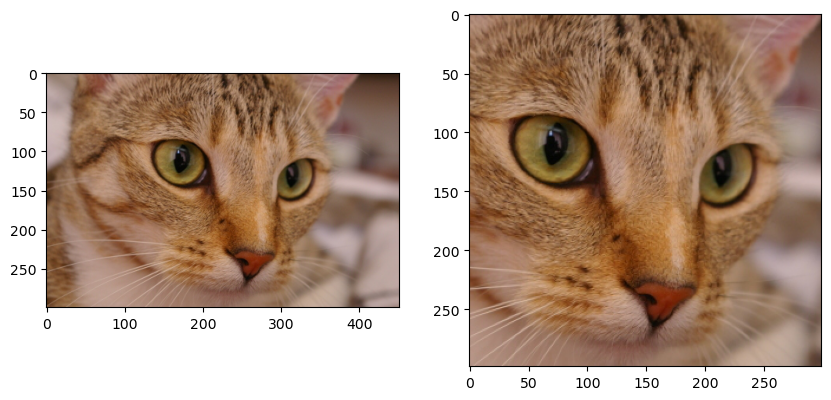

In [ ]:
sz = 299
img_raw = plt.imread('ML3/chelsea.jpg')

img_crop = img_raw.copy()[:sz, 100:100+sz]

_, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(img_raw)
axs[0].grid(False)
axs[1].imshow(img_crop)
axs[1].grid(False)
plt.show()

We need to apply same scaling to the input asa was done for training samples. This is done with a `preprocess_input` method corresponding to a model

In [ ]:
image_chw = img_crop.transpose([2,0,1])
image_chw.shape

(3, 299, 299)

In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor(),  # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # nor,malizsation as trianing data (std on ImageNet trainign set)
])

In [ ]:
image_t = preprocess(img_crop)  # hwc -> chw
image_t.shape

torch.Size([3, 299, 299])

In [ ]:
image_t_bchw = image_t.unsqueeze(0)  # add batch dimension
image_t_bchw.shape

torch.Size([1, 3, 299, 299])

In [ ]:
with torch.no_grad():
    probs = base_model(image_t_bchw)
probs.shape

torch.Size([1, 1000])

In [ ]:
probs = F.softmax(probs, dim=1)[0]

In [ ]:
# get top 5 predictions
top5 = torch.topk(probs, 5)

In [ ]:
indices = top5.indices
probs5 = top5.values

In [ ]:
[class_names[i] for i in indices]

['Egyptian cat', 'tabby', 'tiger cat', 'lynx', 'plastic bag']

In [ ]:
[f'{p:.5f}' for p in probs5]

['0.85541', '0.06757', '0.04786', '0.00069', '0.00034']

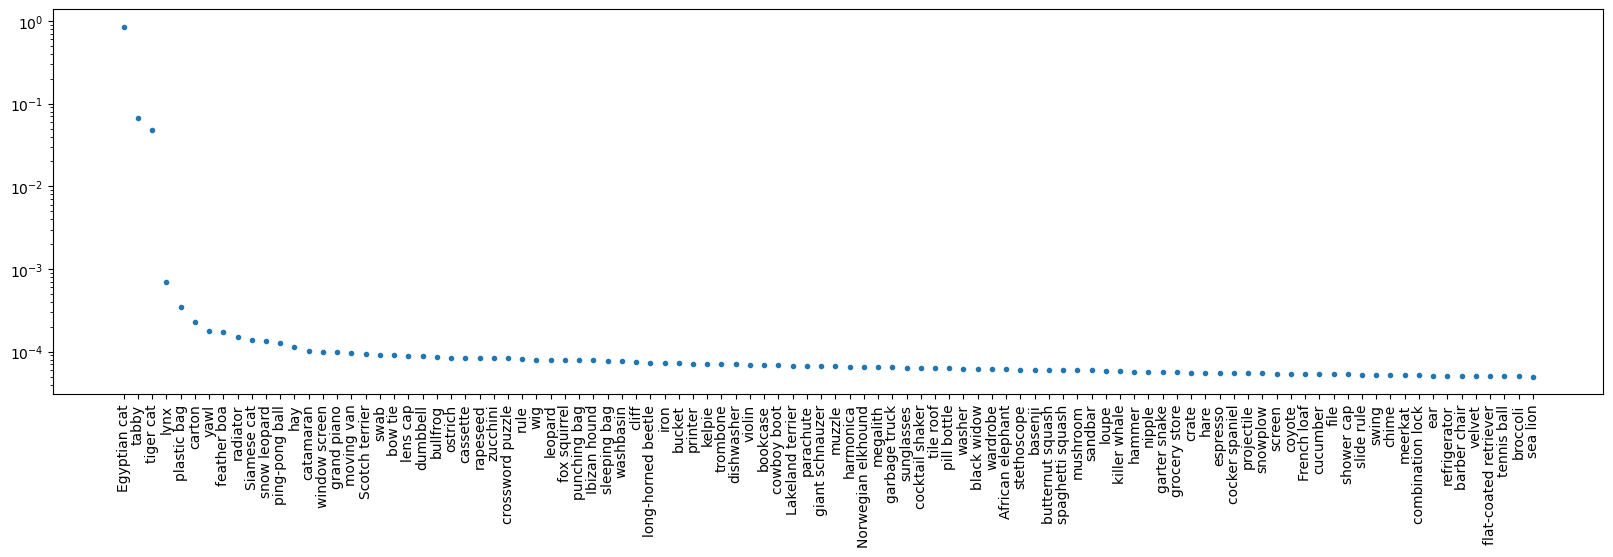

In [ ]:
probs_np = probs.detach().cpu().numpy()
indices = np.argsort(probs_np)[::-1][:100]
probs_s = probs_np[indices]
classes = [class_names[i] for i in indices]

plt.figure(figsize=(20,5))
plt.semilogy(classes, probs_s, '.');
plt.xticks(rotation=90);